In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install anesthetic
import os
os.chdir("/content/drive/MyDrive/project")

In [3]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dists
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, multivariate_normal
from anesthetic.plot import kde_plot_1d, kde_contour_plot_2d
from torch_utils import get_limits, visualise_tension, visualise_coordinate, plot_marginalised_dists
from np_utils import simple_data, curved_data, uniform_prior_samples
from tension_net import TensionNet, TensionNet1
from tension_quantify import BayesFactor, SuspiciousnessKLDiv, LogSuspiciousness

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
X0, X1, X_prior = simple_data()
X0_tensor = torch.tensor(X0).float().to(device)
X1_tensor = torch.tensor(X1).float().to(device)
X_prior_tensor = torch.tensor(X_prior).float().to(device)

(<matplotlib.tri.tricontour.TriContourSet at 0x7ff867573278>,
 <matplotlib.tri.tricontour.TriContourSet at 0x7ff867588128>)

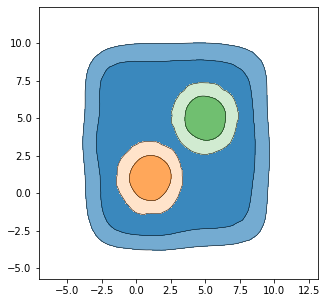

In [6]:
fig, axs = plt.subplots(figsize=(5, 5))

kde_contour_plot_2d(axs, X_prior[:, 0], X_prior[:, 1])
kde_contour_plot_2d(axs, X0[:, 0], X0[:, 1])
kde_contour_plot_2d(axs, X1[:, 0], X1[:, 1])

In [7]:
lrs = torch.pow(10, torch.arange(-10, 1).float())

In [8]:
tension_R = TensionNet1(2).to(device)
criterion = BayesFactor(hist_type="gaussian", hist_param=1, n_dist_bins=100, 
                        n_prior_bins=50).to(device)

losses_R = []

for lr in lrs:
    optimizer = optim.SGD(tension_R.parameters(), lr=lr)
    for i in range(30 if lr.item() != 1 else 100):
        optimizer.zero_grad()
        X0_1d = tension_R(X0_tensor)
        X1_1d = tension_R(X1_tensor)
        X_prior_1d = tension_R(X_prior_tensor)

        loss = criterion(X0_1d, X1_1d, X_prior_1d)
        losses_R.append(loss.item())
        loss.backward()
        optimizer.step()

In [41]:
tension_S = TensionNet1(2).to(device)
criterion = SuspiciousnessKLDiv(hist_type="gaussian", hist_param=1,
                                n_dist_bins=100, n_prior_bins=50,
                                return_extras=True).to(device)

losses_S = []
extras = np.empty((0, 5))

for lr in lrs:
    optimizer = optim.SGD(tension_S.parameters(), lr=lr)
    for i in range(30 if lr.item() != 1 else 100):
        optimizer.zero_grad()
        X0_1d = tension_S(X0_tensor)
        X1_1d = tension_S(X1_tensor)
        X_prior_1d = tension_S(X_prior_tensor)

        (loss, log_R, log_I, 
         kld_A, kld_B, kld_AB) = criterion(X0_1d, X1_1d, X_prior_1d)
        extras = np.concatenate((extras, np.array(
            [[log_R.item(), log_I.item(), 
             kld_A.item(), kld_B.item(), kld_AB.item()]])))
        losses_S.append(loss.item())
        loss.backward()
        optimizer.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


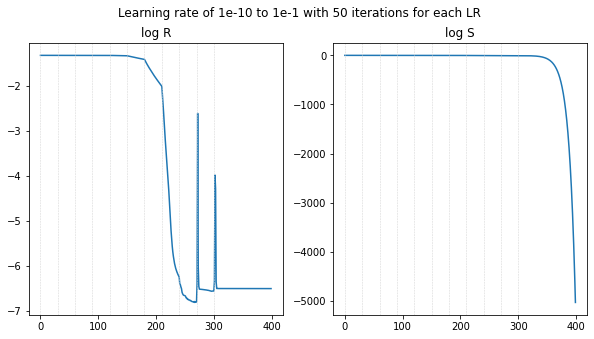

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Learning rate of 1e-10 to 1e-1 with 50 iterations for each LR")
axs[0].plot(np.arange(400), losses_R)
axs[0].set_title("log R")
axs[1].plot(np.arange(400), losses_S)
axs[1].set_title("log S")

for i in range(11):
    axs[0].axvline(30 * i, color='lightgrey', linestyle='--', lw=0.5)
    axs[1].axvline(30 * i, color='lightgrey', linestyle='--', lw=0.5)

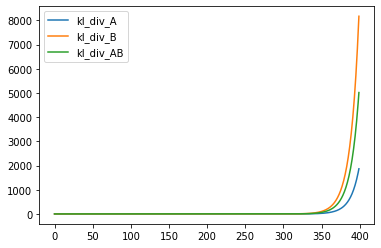

In [45]:
plt.plot(extras[:, 2], label="kl_div_A")
plt.plot(extras[:, 3], label="kl_div_B")
plt.plot(extras[:, 4], label="kl_div_AB")
plt.legend()

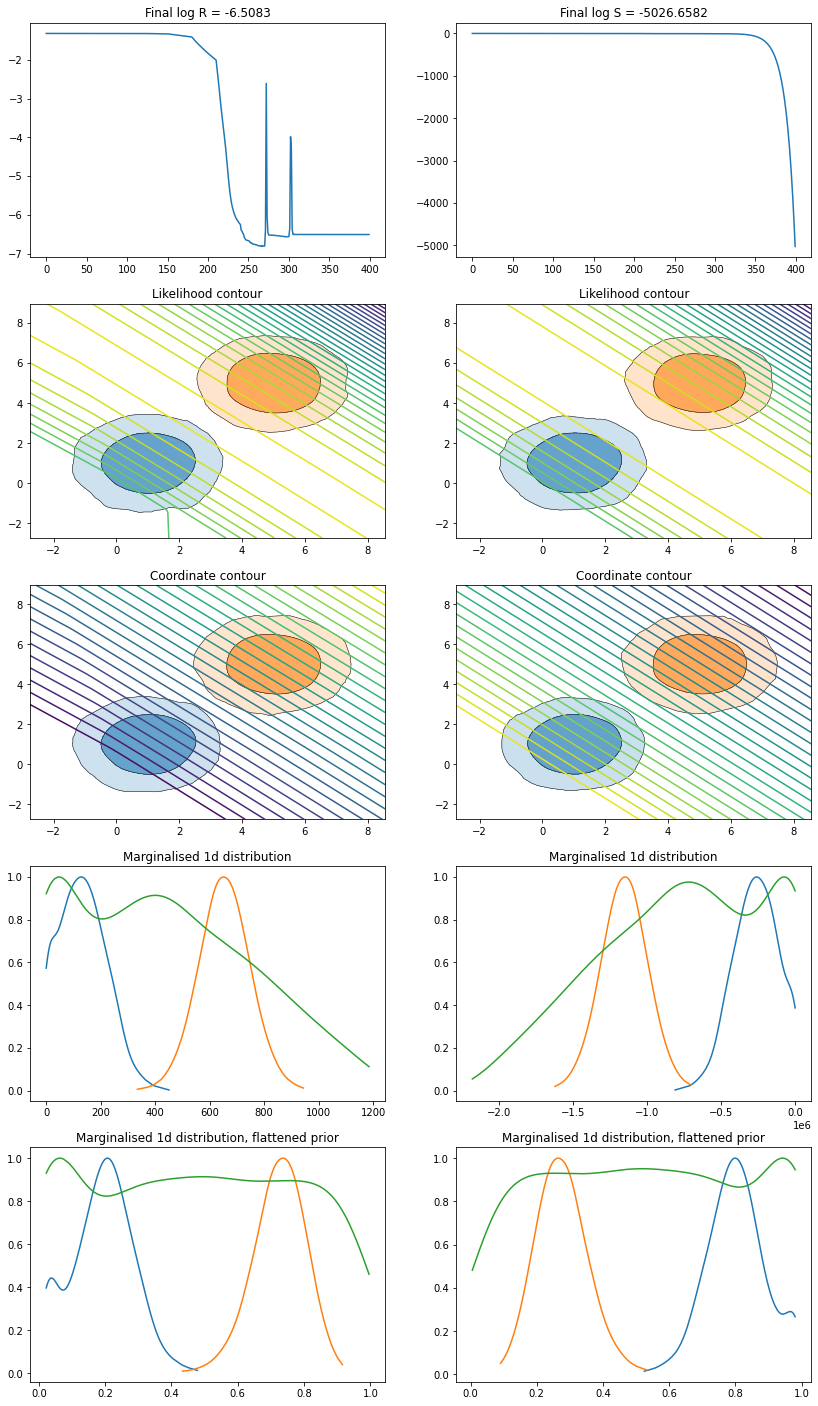

In [48]:
fig, axs = plt.subplots(5, 2, figsize=(14, 25))

axs[0, 0].plot(np.arange(400), losses_R)
axs[0, 0].set_title(f"Final log R = {round(losses_R[-1], 4)}")
X0_1d_R = tension_R(X0_tensor).squeeze().cpu().detach().numpy()
X1_1d_R = tension_R(X1_tensor).squeeze().cpu().detach().numpy()
X_prior_1d_R = tension_R(X_prior_tensor).squeeze().cpu().detach().numpy()
tension_R.to(torch.device("cpu"))
visualise_tension(fig, axs[1, 0], tension_R, X0, X1)
axs[1, 0].set_title("Likelihood contour")
visualise_coordinate(fig, axs[2, 0], tension_R, X0, X1)
axs[2, 0].set_title("Coordinate contour")
axs[3, 0].set_title("Marginalised 1d distribution")
axs[4, 0].set_title("Marginalised 1d distribution, flattened prior")
plot_marginalised_dists(fig, axs[3, 0], X0_1d_R, X1_1d_R, X_prior_1d_R)
plot_marginalised_dists(fig, axs[4, 0], X0_1d_R, X1_1d_R, X_prior_1d_R, flat_prior=True)

axs[0, 1].plot(np.arange(400), losses_S, label='log S')
axs[0, 1].set_title(f"Final log S = {round(losses_S[-1], 4)}")
X0_1d_S = tension_S(X0_tensor).squeeze().cpu().detach().numpy()
X1_1d_S = tension_S(X1_tensor).squeeze().cpu().detach().numpy()
X_prior_1d_S = tension_S(X_prior_tensor).squeeze().cpu().detach().numpy()
tension_S.to(torch.device("cpu"))
visualise_tension(fig, axs[1, 1], tension_S, X0, X1)
axs[1, 1].set_title("Likelihood contour")
visualise_coordinate(fig, axs[2, 1], tension_S, X0, X1)
axs[2, 1].set_title("Coordinate contour")
axs[3, 1].set_title("Marginalised 1d distribution")
axs[4, 1].set_title("Marginalised 1d distribution, flattened prior")
plot_marginalised_dists(fig, axs[3, 1], X0_1d_S, X1_1d_S, X_prior_1d_S)
plot_marginalised_dists(fig, axs[4, 1], X0_1d_S, X1_1d_S, X_prior_1d_S, flat_prior=True)

In [ ]:
X0_c, X1_c, X_prior_c = curved_data()
X0_c_tensor = torch.tensor(X0_c).float().to(device)
X1_c_tensor = torch.tensor(X1_c).float().to(device)
X_prior_c_tensor = torch.tensor(X_prior_c).float().to(device)

(<matplotlib.tri.tricontour.TriContourSet at 0x7f67b50851d0>,
 <matplotlib.tri.tricontour.TriContourSet at 0x7f67b20dba58>)

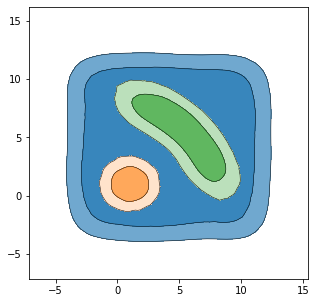

In [ ]:
fig, axs = plt.subplots(figsize=(5, 5))

kde_contour_plot_2d(axs, X_prior_c[:, 0], X_prior_c[:, 1])
kde_contour_plot_2d(axs, X0_c[:, 0], X0_c[:, 1])
kde_contour_plot_2d(axs, X1_c[:, 0], X1_c[:, 1])

In [ ]:
tension_R = TensionNet1(2).to(device)
criterion = BayesFactor(hist_type="gaussian", hist_param=1, 
                        n_dist_bins=100, n_prior_bins=50).to(device)

losses_R = []

for lr in lrs:
    optimizer = optim.Adam(tension_R.parameters(), lr=lr)
    for i in range(30 if lr.item() != 1 else 100):
        optimizer.zero_grad()
        X0_1d = tension_R(X0_c_tensor)
        X1_1d = tension_R(X1_c_tensor)
        X_prior_1d = tension_R(X_prior_c_tensor)
        
        loss = criterion(X0_1d, X1_1d, X_prior_1d)
        losses_R.append(loss.item())
        loss.backward()
        optimizer.step()

In [ ]:
tension_S = TensionNet1(2).to(device)
criterion = SuspiciousnessKLDiv(hist_type="gaussian", hist_param=1,
                                n_dist_bins=100, n_prior_bins=50).to(device)

losses_S = []

for lr in lrs:
    optimizer = optim.Adam(tension_S.parameters(), lr=lr)
    for i in range(30 if lr.item() != 1 else 100):
        optimizer.zero_grad()
        X0_1d = tension_S(X0_c_tensor)
        X1_1d = tension_S(X1_c_tensor)
        X_prior_1d = tension_S(X_prior_c_tensor)
        
        loss = criterion(X0_1d, X1_1d, X_prior_1d)
        losses_S.append(loss.item())
        loss.backward()
        optimizer.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


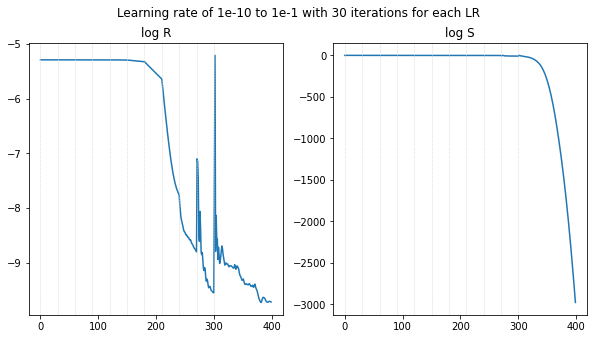

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Learning rate of 1e-10 to 1e-1 with 30 iterations for each LR")
axs[0].plot(np.arange(400), losses_R)
axs[0].set_title("log R")
axs[1].plot(np.arange(400), losses_S)
axs[1].set_title("log S")

for i in range(11):
    axs[0].axvline(30 * i, color='lightgrey', linestyle='--', lw=0.5)
    axs[1].axvline(30 * i, color='lightgrey', linestyle='--', lw=0.5)    

Text(0.5, 1.0, 'Coordinate contour')

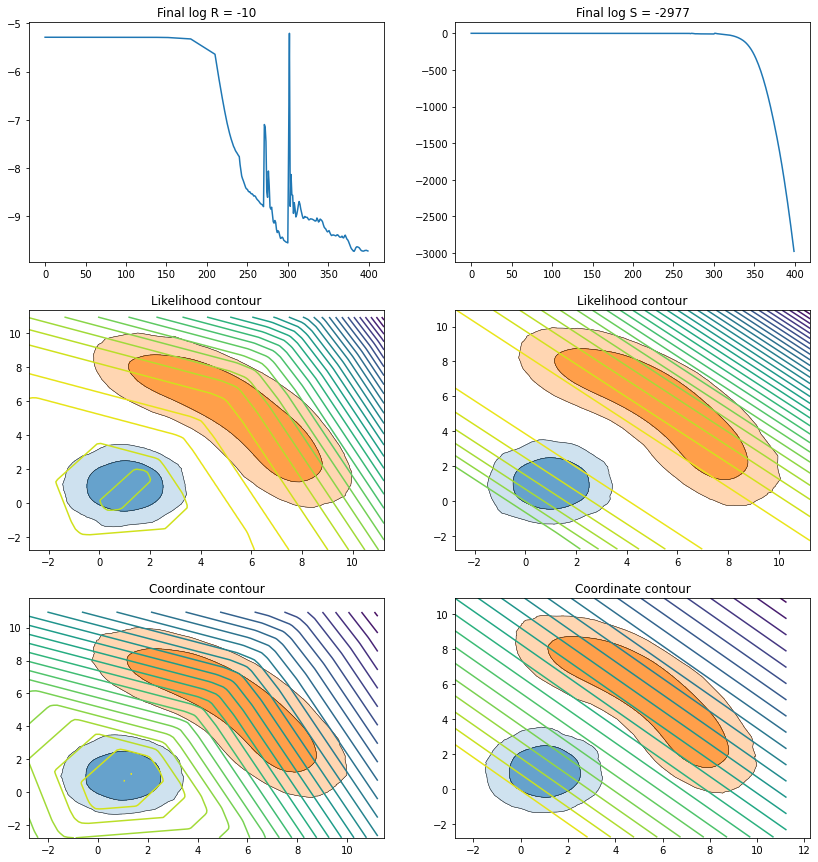

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(14, 15))

axs[0, 0].plot(np.arange(400), losses_R)
axs[0, 0].set_title(f"Final log R = {round(losses_R[-1])}")
X0_c_1d_R = tension_R(X0_c_tensor).squeeze().cpu().detach().numpy()
X1_c_1d_R = tension_R(X1_c_tensor).squeeze().cpu().detach().numpy()
X_prior_c_1d_R = tension_R(X_prior_c_tensor).squeeze().cpu().detach().numpy()
tension_R.to(torch.device("cpu"))
visualise_tension(fig, axs[1, 0], tension_R, X0_c, X1_c)
axs[1, 0].set_title("Likelihood contour")
visualise_coordinate(fig, axs[2, 0], tension_R, X0_c, X1_c)
axs[2, 0].set_title("Coordinate contour")

axs[0, 1].plot(np.arange(400), losses_S)
axs[0, 1].set_title(f"Final log S = {round(losses_S[-1])}")
X0_c_1d_S = tension_S(X0_c_tensor).squeeze().cpu().detach().numpy()
X1_c_1d_S = tension_S(X1_c_tensor).squeeze().cpu().detach().numpy()
X_prior_c_1d_S = tension_S(X_prior_c_tensor).squeeze().cpu().detach().numpy()
tension_S.to(torch.device("cpu"))
visualise_tension(fig, axs[1, 1], tension_S, X0_c, X1_c)
axs[1, 1].set_title("Likelihood contour")
visualise_coordinate(fig, axs[2, 1], tension_S, X0_c, X1_c)
axs[2, 1].set_title("Coordinate contour")

### From both learning rate plots, clear that a learning rate of around 10^-3 to 10^-4 is ideal in terms of learning quickly.